In [1]:
import os
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten
from keras.optimizers import Adam

2024-05-15 18:04:48.964569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 18:04:48.964700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 18:04:49.083937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import xarray as xr
import pandas as pd

# Set the path to the directory where the dataset files are located
data_dir = '/kaggle/input/dataset/'

def load_data(data_dir):
    humidity_data = []
    temperature_data = []
    for file in os.listdir(data_dir):
        if file.startswith("RH"):  # Assuming files starting with "RH" are humidity files
            humidity_file_path = os.path.join(data_dir, file)
            humidity = xr.open_dataset(humidity_file_path)
            humidity_data.append(humidity)
        elif file.startswith("ST"):  # Assuming files starting with "ST" are surface temperature files
            temperature_file_path = os.path.join(data_dir, file)
            temperature = xr.open_dataset(temperature_file_path)
            temperature_data.append(temperature)
    return humidity_data, temperature_data

def dataframes_from_xarray(xr_data):
    dfs = []
    for data in xr_data:
        df = data.to_dataframe().reset_index()
        dfs.append(df)
    return dfs

humidity_data, temperature_data = load_data(data_dir)

humidity_dfs = dataframes_from_xarray(humidity_data)
temperature_dfs = dataframes_from_xarray(temperature_data)


In [3]:
humidity = pd.concat(humidity_dfs)
temperature = pd.concat(temperature_dfs)

In [4]:
humidity

,lon,lat,Humidity
0,68.16,37.079999,NaN
1,68.16,36.959999,NaN
2,68.16,36.839999,NaN
3,68.16,36.719999,NaN
4,68.16,36.599999,NaN
...,...,...,...
62225,97.44,7.199999,NaN
62226,97.44,7.079999,NaN
62227,97.44,6.959999,NaN
62228,97.44,6.839999,NaN


In [5]:
temperature

,lon,lat,Temperature
0,68.16,37.079999,NaN
1,68.16,36.959999,NaN
2,68.16,36.839999,NaN
3,68.16,36.719999,NaN
4,68.16,36.599999,NaN
...,...,...,...
62225,97.44,7.199999,NaN
62226,97.44,7.079999,NaN
62227,97.44,6.959999,NaN
62228,97.44,6.839999,NaN


In [6]:
data = pd.concat([humidity, temperature['Temperature']], axis=1)

# Print the first few rows of the resulting DataFrame
print(data)

         lon        lat  Humidity  Temperature
0      68.16  37.079999       NaN          NaN
1      68.16  36.959999       NaN          NaN
2      68.16  36.839999       NaN          NaN
3      68.16  36.719999       NaN          NaN
4      68.16  36.599999       NaN          NaN
...      ...        ...       ...          ...
62225  97.44   7.199999       NaN          NaN
62226  97.44   7.079999       NaN          NaN
62227  97.44   6.959999       NaN          NaN
62228  97.44   6.839999       NaN          NaN
62229  97.44   6.719999       NaN          NaN

[2675890 rows x 4 columns]


In [7]:
# Filter the original DataFrame to include only rows with non-NaN values
data = data.dropna()

In [8]:
data

,lon,lat,Humidity,Temperature
364,68.28,23.879999,74.984970,309.762970
365,68.28,23.759999,81.160942,305.813080
366,68.28,23.639999,85.675438,302.292175
618,68.40,23.879999,73.076790,310.359985
619,68.40,23.759999,80.919594,305.936737
...,...,...,...,...
61542,97.20,28.199999,88.268639,286.525513
61543,97.20,28.079999,89.079872,286.059998
61544,97.20,27.959999,89.407913,285.915924
61796,97.32,28.199999,86.729660,286.910706


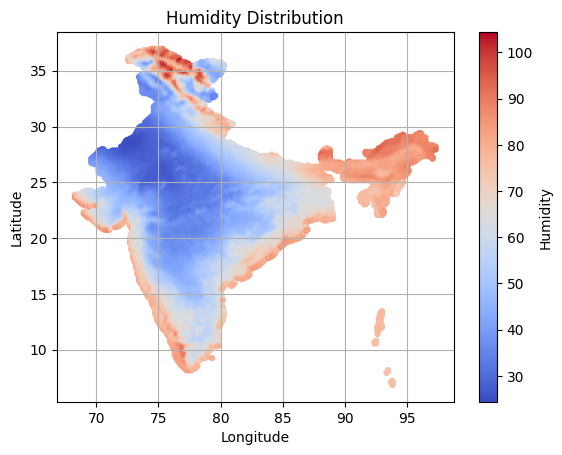

In [ ]:
import matplotlib.pyplot as plt

# Slice the DataFrame to get the first 20178 records
subset_df = data.head(20184)

# Plot lon vs. lat with humidity_avg as the color
plt.scatter(subset_df['lon'], subset_df['lat'], c=subset_df['Humidity'], cmap='coolwarm',marker='.', s=50)
plt.colorbar(label='Humidity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Humidity Distribution')
plt.grid(True)
plt.show()

In [11]:
data = data[['Humidity', 'Temperature', 'lat', 'lon']]
data

,Humidity,Temperature,lat,lon
364,74.984970,309.762970,23.879999,68.28
365,81.160942,305.813080,23.759999,68.28
366,85.675438,302.292175,23.639999,68.28
618,73.076790,310.359985,23.879999,68.40
619,80.919594,305.936737,23.759999,68.40
...,...,...,...,...
61542,88.268639,286.525513,28.199999,97.20
61543,89.079872,286.059998,28.079999,97.20
61544,89.407913,285.915924,27.959999,97.20
61796,86.729660,286.910706,28.199999,97.32


In [12]:
# prompt: do MinMaxScaler() to data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [13]:
data_scaled

array([[0.63986324, 0.89033909, 0.56573705, 0.        ],
       [0.7015377 , 0.82827266, 0.56175299, 0.        ],
       [0.74662033, 0.77294709, 0.55776892, 0.        ],
       ...,
       [0.78389356, 0.51561959, 0.70119522, 0.99586777],
       [0.757148  , 0.53125104, 0.70916335, 1.        ],
       [0.80699136, 0.5100138 , 0.70119522, 1.        ]])

In [14]:
features = data_scaled
target = data_scaled[:,0]

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
train_size = 666072
test_size = 201840

# Splitting the data
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:train_size+test_size]

In [17]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_scaled, train_size=train_size, test_size=test_size, shuffle=False)

In [18]:
x_train = train_data[:,:]
y_train = train_data[:, 0]   # Target variable


x_test = test_data[:,:]
y_test = test_data[:, 0]

In [19]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (666072, 4)
Shape of y_train: (666072,)
Shape of x_test: (201840, 4)
Shape of y_test: (201840,)


In [20]:
win_length=20184
batch_size=200
num_features=4
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [21]:
print("Number of training steps:", len(train_generator))
print("Number of validation steps:", len(test_generator))

Number of training steps: 3230
Number of validation steps: 909


In [22]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(win_length, num_features)))

# Add max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add LSTM layer
model.add(LSTM(64, return_sequences=True))  # Return sequences for stacking LSTM layers

# Add another LSTM layer
model.add(LSTM(32,return_sequences=False))

# Add dropout layer for regularization
model.add(Dropout(0.5))

# Add dense layer
model.add(Dense(1))  # Output layer for regression, no activation function

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Using Mean Squared Error loss for regression

# Print the model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 20182, 64)      │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10091, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10089, 32)      │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10089, 64)      │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,289 (173.00 KB)

 Trainable params: 44,289 (173.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
patience=2,
mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),
optimizer=tf.optimizers.Adam(),
metrics=[tf.metrics.MeanAbsoluteError()])
history = model.fit(train_generator, epochs=10,
validation_data=test_generator,
shuffle=False,
callbacks=[early_stopping])

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3230/3230 ━━━━━━━━━━━━━━━━━━━━ 3521s 1s/step - loss: 0.0112 - mean_absolute_error: 0.0705 - val_loss: 0.0028 - val_mean_absolute_error: 0.0345
Epoch 2/10
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 3516s 1s/step - loss: 0.0031 - mean_absolute_error: 0.0374 - val_loss: 0.0024 - val_mean_absolute_error: 0.0295
Epoch 3/10
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 3518s 1s/step - loss: 0.0028 - mean_absolute_error: 0.0354 - val_loss: 0.0025 - val_mean_absolute_error: 0.0306
Epoch 4/10
3230/3230 ━━━━━━━━━━━━━━━━━━━━ 3523s 1s/step - loss: 0.0027 - mean_absolute_error: 0.0347 - val_loss: 0.0029 - val_mean_absolute_error: 0.0379


In [24]:
model.save("CNN-LSTM-Humidity.h5")

In [25]:
model.evaluate(test_generator, verbose=0)

[0.0029190012719482183, 0.03791919723153114]

In [26]:
predictions = model.predict(test_generator)

909/909 ━━━━━━━━━━━━━━━━━━━━ 398s 438ms/step


In [27]:
predictions.shape

(181656, 1)

In [28]:
predict_df = pd.DataFrame(predictions)

In [29]:
predict_df

,0
0,0.827670
1,0.709271
2,0.613247
3,0.745594
4,0.598828
...,...
181651,0.791058
181652,0.805130
181653,0.810437
181654,0.806006


In [30]:
x_test.shape

(201840, 4)

In [31]:
x_test[:,1:][win_length:]

array([[0.83999062, 0.56573705, 0.        ],
       [0.86394971, 0.56175299, 0.        ],
       [0.85554055, 0.55776892, 0.        ],
       ...,
       [0.51561959, 0.70119522, 0.99586777],
       [0.53125104, 0.70916335, 1.        ],
       [0.5100138 , 0.70119522, 1.        ]])

In [32]:
df_pred = pd.concat([(predict_df), pd.DataFrame(x_test[:,1:][win_length:])], axis = 1)

In [33]:
df_pred

,0,0,1,2
0,0.827670,0.839991,0.565737,0.000000
1,0.709271,0.863950,0.561753,0.000000
2,0.613247,0.855541,0.557769,0.000000
3,0.745594,0.863898,0.565737,0.004132
4,0.598828,0.875960,0.561753,0.004132
...,...,...,...,...
181651,0.791058,0.525198,0.709163,0.995868
181652,0.805130,0.517883,0.705179,0.995868
181653,0.810437,0.515620,0.701195,0.995868
181654,0.806006,0.531251,0.709163,1.000000


In [34]:
pred = df_pred.tail(20184)

In [35]:
rev = scaler.inverse_transform(pred)

In [36]:
rev

array([[ 92.54822992, 310.48471069,  23.879999  ,  68.28      ],
       [ 77.13980526, 306.12390137,  23.759999  ,  68.28      ],
       [ 68.07213797, 302.3309021 ,  23.639999  ,  68.28      ],
       ...,
       [ 92.06592281, 285.91592407,  27.959999  ,  97.2       ],
       [ 91.62222128, 286.91070557,  28.199999  ,  97.32      ],
       [ 90.41795166, 285.55917358,  27.959999  ,  97.32      ]])

In [37]:
df_final = data[pred.shape[0]*-1:]

In [38]:
df_final.count()

Humidity       20184
Temperature    20184
lat            20184
lon            20184
dtype: int64

In [39]:
df_final["Predicted"] = rev[:,0]

/tmp/ipykernel_34/43512189.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Predicted"] = rev[:,0]


In [40]:
df_final

,Humidity,Temperature,lat,lon,Predicted
364,67.783073,310.484711,23.879999,68.28,92.548230
365,75.658440,306.123901,23.759999,68.28,77.139805
366,80.804504,302.330902,23.639999,68.28,68.072138
618,65.312943,311.363403,23.879999,68.40,85.745041
619,75.065788,306.361420,23.759999,68.40,63.018293
...,...,...,...,...,...
61542,88.268639,286.525513,28.199999,97.20,90.125306
61543,89.079872,286.059998,28.079999,97.20,91.534541
61544,89.407913,285.915924,27.959999,97.20,92.065923
61796,86.729660,286.910706,28.199999,97.32,91.622221


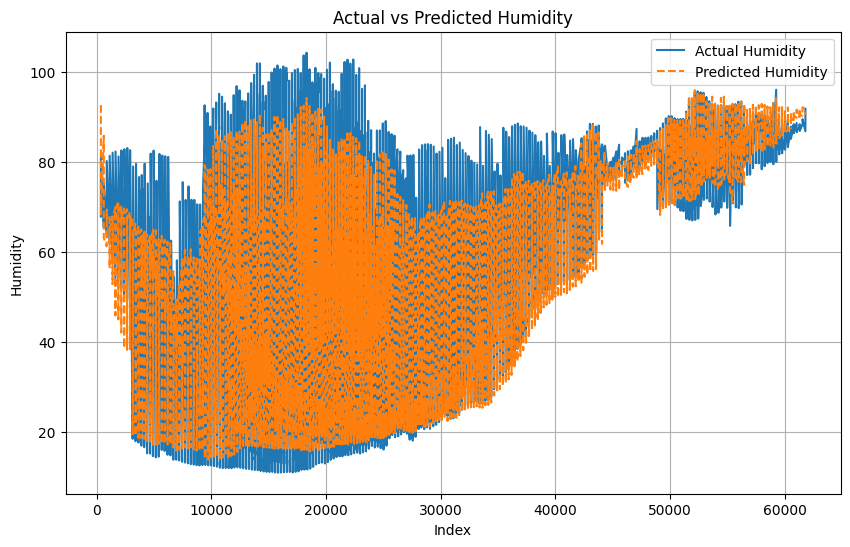

In [50]:
import matplotlib.pyplot as plt

# Extract humidity_avg and Predicted columns
humidity_avg = df_final['Humidity']
predicted = df_final['Predicted']

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(humidity_avg, label='Actual Humidity')
plt.plot(predicted, label='Predicted Humidity', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(df_final['Humidity'], df_final['Predicted'])
print('Mean Absolute Error (MAE):', mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(df_final['Humidity'], df_final['Predicted'])
print('Mean Squared Error (MSE):', mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(df_final['Humidity'], df_final['Predicted'], squared=False)
print('Root Mean Squared Error (RMSE):', rmse)

# Calculate R-squared (Coefficient of determination)
r2 = r2_score(df_final['Humidity'], df_final['Predicted'])
print('R-squared (Coefficient of determination):', r2)


Mean Absolute Error (MAE): 3.622683025617445
Mean Squared Error (MSE): 30.119519494733343
Root Mean Squared Error (RMSE): 5.4881253169669275
R-squared (Coefficient of determination): 0.9436481622236035


In [46]:
# Extracting the columns for the first dataframe
first_df = df_final[['Humidity', 'Temperature', 'lat', 'lon']]

# Extracting the columns for the second dataframe
second_df = df_final[['Temperature', 'lat', 'lon', 'Predicted']]

# Displaying the first dataframe
print("First Dataframe:")
print(first_df.head())

# Displaying the second dataframe
print("\nSecond Dataframe:")
print(second_df.head())


First Dataframe:
      Humidity  Temperature        lat    lon
364  67.783073   310.484711  23.879999  68.28
365  75.658440   306.123901  23.759999  68.28
366  80.804504   302.330902  23.639999  68.28
618  65.312943   311.363403  23.879999  68.40
619  75.065788   306.361420  23.759999  68.40

Second Dataframe:
     Temperature        lat    lon  Predicted
364   310.484711  23.879999  68.28  92.548230
365   306.123901  23.759999  68.28  77.139805
366   302.330902  23.639999  68.28  68.072138
618   311.363403  23.879999  68.40  85.745041
619   306.361420  23.759999  68.40  63.018293


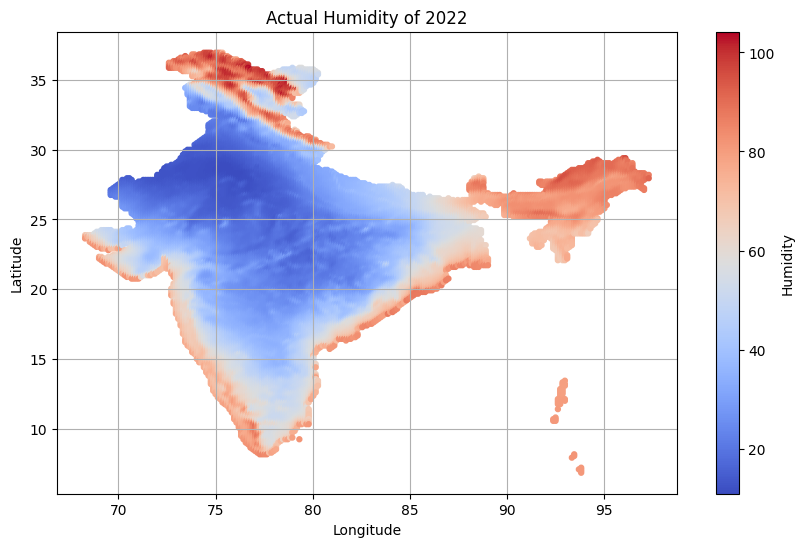

In [48]:
import matplotlib.pyplot as plt

# Assuming df_cleaned has already been defined

# Reset index to make the columns 'lat' and 'lon' accessible for plotting
first_df.reset_index(inplace=True)

# Extract latitudes, longitudes, and humidity_avg values
latitudes = first_df['lat']
longitudes =first_df['lon']
humidity_avg =first_df['Humidity']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(longitudes, latitudes, c=humidity_avg, cmap='coolwarm',marker='.', s=50)
plt.colorbar(label='Humidity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Actual Humidity of 2022')
plt.grid(True)
plt.show()


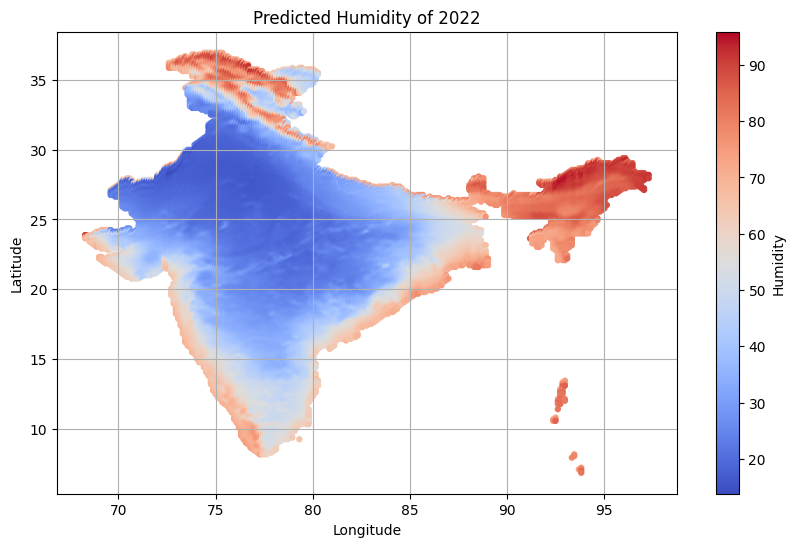

In [49]:
import matplotlib.pyplot as plt

# Assuming df_cleaned has already been defined

# Reset index to make the columns 'lat' and 'lon' accessible for plotting
second_df.reset_index(inplace=True)

# Extract latitudes, longitudes, and humidity_avg values
latitudes = second_df['lat']
longitudes =second_df['lon']
humidity_avg =second_df['Predicted']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(longitudes, latitudes, c=humidity_avg, cmap='coolwarm',marker='.', s=50)
plt.colorbar(label='Humidity')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Humidity of 2022')
plt.grid(True)
plt.show()
